# Differentiable programming for lumped MHFEM

## Problem formulation and solution

### Overview

When working with liquids in porous media, it is often the case that only certain scalar values depending on the liquids' distribution are measurable (e.g. particle flow through a detector located underneath the porous media volume).
It is natural that fro this arises the problem of determining the behavior of these values with respect to parameters of said media.

Here, a numeric differentiation model is developed atop of lumped MHFE (LMHFE) method suggested by Yones et al. [1] __(TODO: Give a proper reference!)__ for the case of single-phase two-dimensional liquid flow.
Corresponding differential equations are
$$
\begin{cases}
    c\frac{\partial P}{\partial t} + \vec \nabla \vec q = f\text{ in }\Omega \\
    \vec q = -a \vec\nabla P
\end{cases}
\tag{1}
$$
with Dirichlet ($P = P_d$ on $\partial \Omega_D$) and Neumann($-a\frac{\partial P}{\partial \vec\eta} = g$ on $\partial \Omega_N$) boundary conditions.

Our goal is to determine sensitivity

The solution is found with LMHFE [1] via an introduction of a triangulated solution domain mesh.
In these terms, $P$, $a$ and $c$ become vectors $\vec P$, $\vec a$ and $\vec c$ with $i$-th vector elements corrseponding to their mean values over $i$-th triangle (generally speaking, cells aren't required to be triangular, but this is the cell topology we will be using in this case).

The method derives the solution in two steps: first, a linear system provides an edge-wise solution $\vec P_T$ ($i$-th element is a mean value of solution $P$ over $i$-th edge in the mesh):
$$
M\vec P_T^{[i]} = \vec b \left( \vec P_T^{[i-1]} \right)
\tag{2}
$$
that is then converted to $\vec P$ via
$$
P_i^{[i]} = \frac{a_i}{\beta_i} \sum\limits_{\text{edge }j \in \text{ boundary of }i} \alpha_{ij} P_{T,j}^{[i]} + \frac{\lambda_i}{\beta_i}\vec P^{[i-1]} + \frac{Q_{S,i}}{\beta_i}
\tag{3.1}
$$

Here and later indices like $^{[i]}$ denote solution time step.
$\alpha_{ij}$ is a geometric coefficient that could be found in [1], and
$$
\lambda_i = \frac{c_i \left|A_i\right|}{\tau}, \alpha_i = \sum\limits_j \alpha_{ij}, \beta_i = \lambda_i + a_i\alpha_i,
$$
where $\tau$ is solution time step.
$Q_{S,i}$ is a value proportional to a mean value of $f$ over $i$-th cell and is, in our case, zero.
__(3.1)__ could also be rewritten as:
$$
\vec P^{[i]} = U \vec P_T^{[i]} + V \vec P^{[i-1]}
\tag{3.2}
$$
with $U_{ij} = \frac{a_i \alpha_{ij}}{\beta_i}$ if $j \in \partial_i$ ($i$-th cell edge), $U_{ij}=0$ otherwise and $V_{ii} = \frac{\lambda_i}{\beta_i}$, $V_{ij} = 0$, $i \ne j$.

### Scalar function sensitivity

#### Differentiating LMHFE

We're interested in the derivative $\frac{dg}{d\vec a}$ of some scalar function $g=g(\vec P, \vec a)$.
Applying chain rule:
$$
\frac{dg}{d\vec a}^{[i]}
=
    \frac{\partial g}{\partial \vec a}
    +
    \frac{\partial g}{\partial \vec P^{[i]}}
    \frac{d\vec P^{[i]}}{d\vec a}
.
\tag{4}
$$

$\frac{\partial g}{\partial \vec a}$ and $\frac{\partial g}{\partial \vec P^{[i]}}$ could be calculated from knowing an analytical formula for $g$.
The point of interest is to calculate $\frac{d\vec P^{[i]}}{d \vec a}$.
For this, we will differentiate __(3.2)__:

$$
\frac{d\vec P^{[i]}}{d\vec a}
=
\left( \frac{dU}{d\vec a} \right)
\vec P_T^{[i]}
+
U\frac{d\vec P_T^{[i]}}{d \vec a}
+
V \frac{d\vec P^{[i-1]}}{d \vec a}
+
\left(\frac{dV}{d\vec a}\right)\vec P^{[i-1]}.
\tag{5}
$$

Let's determine $\left(\frac{dU}{d\vec a}\right)\vec P_T^{[i]}$:
$$
\left(\frac{dU}{d\vec a}\right)\vec P_T^{[i]}
=
\left[
    \frac{dU}{da_1}\vec P_T^{[i]}
    \biggr|
    \frac{dU}{da_2}\vec P_T^{[i]}
    \biggr|
    ...
    \biggr|
    \frac{dU}{da_j}\vec P_T^{[i]}
    \biggr|
    ...
\right]
\tag{6}
$$

Since $U_{ij} = \frac{a_i \alpha_{ij}}{\beta_i}$ for $j \in \partial_i$ and zero otherwise, then $\left(\frac{dU}{da_k}\right)_{ij}$ is zero for all $i \ne k$ or $j \notin \partial i$ which means that $\left(\frac{dU}{d\vec a}\right)\vec P_T^{[i]}$ is diagonal.
For other $i$, $j$, $k$:
$$
\left(\frac{dU}{da_k}\right)_{ij} \bigg|_{i=k} =
\frac{d}{da_i}\left(\frac{a_i\alpha_{ij}}{\beta_i}\right)
=
\frac{\alpha_{ij}\lambda_i}{\beta_i^2}.
\tag{7}
$$

Similarly,
$$
\left(\frac{dV}{da}\right)\vec P^{[i-1]} = -\frac{\alpha_i\lambda_i}{\beta_i^2} \vec P^{[i-1]}.
\tag{8}
$$

All that's left to evaluate is $\frac{d\vec P_T^{[i]}}{d\vec a}$. Differentiating __(2)__ gives
$$
M \frac{d\vec P_T^{[i]}}{d\vec a}
=
\frac{\partial \vec b}{\partial \vec a}
+
\frac{\partial \vec b}{\partial \vec P_T^{[i-1]}}
\frac{d \vec P_T^{[i-1]}}{d\vec a}
-
\left(\frac{dM}{d\vec a}\right) \vec P_T^{[i]}.
\tag{9}
$$

$\left(\frac{dM}{d\vec a}\right) \vec P_T^{[i]}$ is calculated similarly to __(6)__ as a matrix composed of row vectors $\frac{dM}{da_k} \vec P_T^{[i]}$, and $\frac{d \vec P_T^{[i]}}{d \vec a}$ is composed of row vectors that are solutions to
$$
M\frac{d\vec P_T^{[i]}}{d a_k} = \frac{\partial \vec b}{\partial a_k} + \frac{\partial \vec b}{\partial \vec P_T^{[i-1]}}\frac{d \vec P_T^{[i-1]}}{d a_k} - \frac{dM}{d a_k} \vec P_T^{[i]}.
\tag{10}
$$

Initial conditions don't depend on $a$:
$$
\frac{d\vec P^{[0]}}{d\vec a} = 0, \frac{d\vec P_T^{[0]}}{d\vec a} = 0.
$$

#### LMHFE matrices derivatives

Derivatives for $U$ and $V$ are already found in __(7)__ and __(8)__.

In __(2)__:
$$
M = \left(m_{ij}\right)
$$
$$
m_{ii} = m_{ii,k_1} + m_{ii,k_2}, m_{ii,k} = a_k \left( \left( B^{-1}_{ii} \right)_k - \frac{\alpha^2_{ki}}{\alpha_k} \right) + \frac{1}{3} \frac{c_k \|A_k\|}{\tau}
\tag{11.1}
$$
$$
m_{ij} = a_k \left( \left(B_{ij}^{-1}\right)_k - \frac{\alpha_{ki}\alpha_{kj}}{\alpha_k}\right)
\tag{11.2}
$$
where $k_1$, $k_2$ are cells adjacent to $i$-th edge, $\|A_k\|$ is the measure of $k$-th cell, and $B^{-1}$ depends on geometry [1], $k$ is a cell that is adjacent to both $i$-th and $j$-th edges.

Therefore, $\frac{dM^{[i]}}{da_k}$ will only contain elements corresponding to edges $i,j \in \partial_k$.
$$
\left(\frac{dM}{da_k}\right)_{ij} = \begin{cases}
0\text{ if } i,j \notin \partial_k \\
2\left(\left(B_{ii}^{-1}\right)_k - \frac{\alpha_{ki}^2}{\alpha_k}\right)\text{ if }i = j \in \partial_k \\
\left(B_{ij}^{-1}\right)_k-\frac{\alpha_{ki}\alpha_{kj}}{\alpha_k}\text{ if } i \ne j\text{ and }i,j \in \partial_k
\end{cases}
\tag{12}
$$

For $\vec b$:

$$
\left(\vec b\right)_i
=
\frac{c_k \left(\|A_{k_1}\| + \|A_{k_2}\|\right)\left(\vec P_T^{[i-1]}\right)_i}{3\tau}
\tag{13}
$$

It's easy to see that
$$
\frac{\partial \vec b}{\partial \vec a} = \vec 0
$$
and
$$
\left(
    \frac{\partial \vec b}{\partial \vec P_T^{[i-1]}}
\right)_{ii}
=
\frac{c\left(\|A_{k_1}\| + \|A_{k_2}\|\right)}{3\tau},
\tag{14.1}
$$
$$
\left(
    \frac{\partial \vec b}{\partial \vec P_T^{[i-1]}}
\right)_{ij} = 0\ \forall i \ne j
\tag{14.2}
$$
&mdash; $\frac{\partial \vec b}{\partial \vec P_T^{[i]}}$ is a diagonal matrix.

### Complexity

Let's give a crude evalutaion to the solution complexity.

Suppose the mesh has $N$ cells and $K$ edges.
LMHFE solution requires us:
* Compute $U$ (once) of size $N\times K$ which has at most $3$ non-zero elements per row (true size less or equal to $3N$)
* Construct $\vec b$ of $K$ elements
* Construct $M$ of size $K\times K$
  This is a very sparse matrix, containing at most $5$ (for triangular cells) elements per row ($i$-th row might have non-empty elements only in columns corresponding to edges of cells adjacent to $i$-th edge), so the true size of it is less than $5K$
* Solve $M\vec P_T^{[i]} = \vec b$
* Compute $V\vec P^{[i-1]}$ &mdash; $N$ operations
* Compute $U\vec P_T^{[i]}$ &mdash; $3N$ operations
* Perform $N$ additions to get $\vec P^{[i]}$.

Sensitivity calculation requires additionally:
* Compute $\frac{dM}{da_k}$ &mdash; $N$ times less than $6K$ elements each &mdash; less than $N\times 6K$ operations (once, if time step doesn't vary)
* Compute $\frac{\partial \vec b}{\partial \vec P_T^{[i-1]}}$ &mdash; $K$ elements since the matrix is diagonal (once, if time step doesn't vary)
* Solve $N$ linear systems for $\frac{d\vec P_T^{[i]}}{d\vec a}$, similar in preparation and solution complexity to LMHFE system. Right-hand sides of these systems include matrix-vector multiplications that have a complexity of $N\times 6K^2$ at most.
* Compute $\frac{dU}{d\vec a}$ (once) &mdash; $3N$ operations
* Compute $\frac{d\vec P^{[i]}}{d\vec a}$ with $\propto N$ operations

For big $N$ and $K$ ($N < K$), the most complex operation will require $\propto NK^2$ flops that will determine the complexity of the entire method.

### Adjoint methods

Another differentiable programming approach is the use of adjoint methods.
These methods utilize re-ordering of matrix multiplication in order to optimize the computation complexity.
There are several reasons they weren't used in this case:
* Adjoint methods benefit greatly when multiplication reordering converts chains of matrix-matrix multiplications into chains of matrix-vector multiplications in simple recursive problems.
  Two-step recursive nature of the LMHFE solution process makes it very hard to benefit from that kind of reordering _(does it? should we elaborate?)_
* Adjoint methods complexity and memory consumption grows linearly with time, which may be devastating in case of very high-resolution meshes

Although comparing adjoint methods to a more strightforward chain rule differntiation requires further investigation, these points make the first very unappealing for this task.
Furthermore, increasing amounts of required data will make it harder to port the code making use of adjoint methods to GPU since VRAM amount is usually less than RAM, and copying large volumes of data to the GPU could become a serious bottleneck for the computation.

## Code demonstration

_See also: [Known issues](#Known-code-issues)._

### NOA Torch extension

For the sake of demonstration, our C++ implementation is exposed to Python via a Torch C++ extension.
Though the solver itself doesn't use `libtorch`, it is very handy to expose our data as Torch tensors.
Additionally, Torch provides a way to compile and load the code on-the-fly, eliminating the process of building .so-s manually.

In [1]:
from torch.utils.cpp_extension import load
import torch

# Numpy, numba and math are needed for some pure python functions
import numpy as np
from numba import njit
import math

No CUDA runtime is found, using CUDA_HOME='/opt/cuda'


Now we need to specify NOA root path and some of the compiler flags.
`CALCULATE_CHAIN=true` needs to be defined in order to enable chain rule derivative calculation (_FXIME: I haven't actually implemented feature selection, so, instead of compiling without this feature, it will probably throw a compile-time error_).
You can also specify the type to use for real numbers by settings `REAL=type_name` (e.g. `-DREAL=double`).

If `stash/build` directory does not exist, it should be created.
_Note: sometimes if the first build fails, Torch would not compile the extension. To fix that, clean the buil directory and restart the notebook._

In [2]:

# NOA root path
NOA_PATH = "../.."

# Enable chain rule derivative calculation
FEATURES = "-DCALCULATE_CHAIN=true"
# FEATURES += " -DREAL=double"

# Make build dir
! mkdir -p stash/build

# Optional warning flags. We don't want them
WARN_FLAGS = ""
# WARN_FALGS = "-Wall -Wextra -Wpedantic"

#### _If running this notebook outside of NOA_
_If you've obtained this notebook without cloning [NOA](https://github.com/grinisrit/noa), you need to do that manually. This could be done by uncommenting and executing the following cell:_

In [3]:
# Uncomment and execute this cell ONLY if you are running this notebook outside of NOA repository
"""
! [ -d stash ] && rm -rf stash
!mkdir -p stash
!cd stash && git clone https://github.com/gregthemadmonk/noa.git && cd noa && git checkout feature/cfd
# Merge into grinisrit/noa and update the link

NOA_PATH = "stash/noa"
"""

'\n! [ -d stash ] && rm -rf stash\n!mkdir -p stash\n!cd stash && git clone https://github.com/gregthemadmonk/noa.git && cd noa && git checkout feature/cfd\n# Merge into grinisrit/noa and update the link\n\nNOA_PATH = "stash/noa"\n'

Now that the necessary setup has been perform, the extension could be compiled and loaded:

In [4]:
mhfem = load(
            name = "mhfem",
            build_directory = "./stash/build",
            sources = [ f"{NOA_PATH}/test/cfd/mhfe/torch/mhfe_extension.cc" ],
            extra_include_paths = [ f"{NOA_PATH}/src", f"{NOA_PATH}/test/cfd" ],
            extra_cflags = [ f"{WARN_FLAGS} -O3 -std=c++17 -DNDEBUG {FEATURES}" ],
            verbose = False
            )

Check everything is loaded:

In [5]:
mhfem.hi()

Hello from NOA MHFEM solver module!
Info about this module:
	Real type:                       float
	Cell topology:                   noa::TNL::Meshes::Topologies::Triangle
	Write precise solution:          false
	Calculate chain rule derivative: true


### Importing other required modules

We will be using [PyVista](https://docs.pyvista.org/#) to display our meshes and for more traditional 2D plots we will be using [`matplotlib.pyplot`](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html).

In [6]:
import pyvista as pv
import matplotlib.pyplot as plt

### LMHFEM solution

For uniform $a$, and $c=1$ and inlet conditions:
$$
P = h(y)\text{ for }x = 0
$$
and for
$$
h(y) = \begin{cases}A, |y| < \delta \\0, |y| > \delta\end{cases}
$$
the analytical solution is known:
$$
P(x, y, t) = \frac{x A}{\sqrt{16\pi a}}\int\limits_0^t\tau^{-\frac 3 2} \left[ \text{erf } \frac{\delta + y}{\sqrt{4a\tau}} + \text{erf } \frac{\delta - y}{\sqrt{4a\tau}} \right] \cdot \exp \left[ - \left( \frac{x}{\sqrt{4a\tau}} \right)^2 \right] d\tau
$$

Let's solve the problem over a $20\times 10$ mesh for uniform $a = 1$, $c = 1$ and the following boundary conditions:
$$
\begin{cases}
x=const\text{ boundary} \begin{cases}
P_T = 1\text{ when }x = 0\text{ and }1 \le y \le 9 \\
P_T = 0\text{ when }x = 1\text{ or } x = 0\text{ and }y \notin [1;9]
\end{cases}\\
y=const\text{ boundary }\frac{\partial P}{\partial \eta} = 0
\end{cases}
$$
which corrseponds to the solution above with $A = 1$, $\delta = 4$, and $y$ offset by $5$ ($y \rightarrow y - 5$).

In [7]:
@njit
def solPrecise(point, T, tau, delta = 4):
    x = point[0]
    y = point[1]
    def kernel(t):
        sr4at = math.sqrt(4 * t)
        return math.pow(t, -1.5) * (
                math.erf((delta - (y - 5)) / sr4at) + math.erf((delta + (y - 5)) / sr4at)
            ) * math.exp(-math.pow(x / sr4at, 2))
    integral = 0
    t0 = tau
    while t0 < T:
        integral += kernel(t0) * tau
        t0 += tau
    return x * integral / math.sqrt(16 * math.pi)

_TODO: Add a picture, maybe?_

First, we need to create the solver and initialize the mesh geometry:

In [8]:
# Create the solver
solver = mhfem.Solver()
# Generate a 20x10 triangular mesh (elements: triangle 0.5x0.5 square halfs -> 40x10x2 triangles)
mhfem.generate2DRect(solver.getDomain(), 40, 20, 0.5, 0.5) # domain, Nx, Ny, dx, dy

Aside from storing the mesh itself, the domain also handles mesh data layers and file I/O.
It could be converted to a PyVista mesh object with the `.vistify()` method:

In [9]:
solver.getDomain().vistify()

UnstructuredGrid,Information
N Cells,1600
N Points,861
X Bounds,"0.000e+00, 2.000e+01"
Y Bounds,"0.000e+00, 1.000e+01"
Z Bounds,"0.000e+00, 0.000e+00"
N Arrays,0


Before we could proceed, we need to ask the solver object to populate the domain with data layers required for the solution:

In [10]:
solver.updateLayers()

Now the layers are allocated and we can set initial/boundary conditions for our problem:

1. Boundary conditions

In [11]:
def setBoundaryEdge(edgeIndex, p1, p2):
    r = p2 - p1
    
    if r[0] == 0: # x = const
        # Dirichlet boundary conditions
        mask = (p1[0] == 0) and ((p1 + r/2)[1] > 1) and ((p1 + r/2)[1] < 9)
        value = 1 if mask else 0
        
        # Boundary conditions
        solver.getLayer("dirichletMask")[edgeIndex] = 1
        solver.getLayer("dirichlet")[edgeIndex]     = value
        # Initial conditions
        solver.getLayer("edgeSolution")[edgeIndex]  = value
    elif r[1] == 0: # y = const
        # Neumann boundary conditions
        solver.getLayer("neumannMask")[edgeIndex] = 1
        solver.getLayer("neumann")[edgeIndex]     = 0 # \partial P/\partial \eta

solver.getDomain().getMesh().forBoundary(setBoundaryEdge)

2. Problem coefficients:

In [12]:
solver.getLayer("a")[:] = 1
solver.getLayer("c")[:] = 1

3. Automatically pre-calculate some of the required values

In [13]:
solver.cache()

The solver is now ready to perform the solution.
Let's calculate first 10000 steps of it and draw the results to a GIF with PyVista:

In [14]:
# Create a PyVista plotter
gifPlotter = pv.Plotter(notebook=False, off_screen=True)
gifPlotter.open_gif("stash/demo1.gif")

steps = 10_000
for i in range(steps):
    solver.step("lmhfe")
    # Write only every 100th frame
    if i % 100 == 0:
        gifPlotter.clear()
        gifPlotter.add_mesh(solver.getDomain().vistify(), scalars="Computed solution")
        gifPlotter.add_title(f"Frame {i}")
        gifPlotter.write_frame()
    print(f"{i + 1}/{steps}", end='\r')

gifPlotter.close()

Here, our GIF is diplayed with Python.
We need to change image URL every time with a dummy request parameter in order to ensure the image is updated every time the cell is rerun.
_TODO: Do we need this in a ready notebook?_

In [15]:
import IPython
import random
size=600
IPython.display.HTML(
    f"""
    <div style='text-align: center;'>
        <img
            width={size}
            height={size}
            style='display: inline;'
            src='stash/demo1.gif?dummy={random.randint(0, 10)}'
        />
    </div>
    """
) # `randint` forces image update

Let us also calculate precise solution and write it onto the mesh for comparison.

The following code is a relatively crude approximation: instead of calculating the mean value of solution the cell, it only evaluates it at its center.
Also, rectangular integration used in it is suboptimal.
Still, this presents a good demonstration of numerical solution's accuracy.

In [16]:
cmpsol = solver.getDomain().vistify()
cells = solver.getDomain().getMesh().getEntitiesCount(2)
precise = np.zeros(cells)
def fillPrecise(cidx, p1, p2, p3):
    precise[cidx] = solPrecise(np.array((p1 + p2 + p3) / 3), solver.getT(), solver.getTau(), 4)
    #print(f"Cell {cidx}/{cells} solution={precise[cidx]}", end='\r')
    
solver.getDomain().getMesh().forAllCells(fillPrecise)
cmpsol.cell_data.set_array(precise, "Precise solution")
cmpsol.cell_data.set_array(np.abs(precise - np.array(solver.getLayer("solution"))), "Solution error")

In [17]:
plotter = pv.Plotter(notebook=False, off_screen=True)

plotter.clear()
plotter.add_mesh(cmpsol, scalars="Computed solution")
plotter.screenshot("stash/comp.png", window_size=(600, 800))
plotter.clear()
plotter.add_mesh(cmpsol, scalars="Precise solution")
plotter.screenshot("stash/precise.png", window_size=(600, 800))
plotter.clear()
plotter.add_mesh(cmpsol, scalars="Solution error")
plotter.screenshot("stash/error.png", window_size=(600, 800))

rnd=random.randint(0, 1000) # Random number, again, enforces image updates
IPython.display.HTML(
    f"""
    <div style='display: flex; align-items: baseline; justify-content: space-between;'>
        <img style='height: 100%; width: 33%; display: inline;' src='stash/comp.png?{rnd}' />
        <img style='height: 100%; width: 33%; display: inline;' src='stash/precise.png?{rnd}' />
        <img style='height: 100%; width: 33%; display: inline;' src='stash/error.png?{rnd}' />
    </div>
    """
)

This result is expected: analytical solution assumes infinite domain and $\frac{\partial P}{\partial y} = 0$ across its entire area, so the error grows around $y = const$ borders.
Let us perform the same experiment with a smaller $\delta$ ($\delta = 1$) and higher precision:

In [18]:
solver.reset()
mhfem.generate2DRect(solver.getDomain(), 80, 40, 0.25, 0.25)
solver.updateLayers()
def setBoundaryEdge2(edgeIndex, p1, p2):
    r = p2 - p1
    
    if r[0] == 0: # x = const
        # Dirichlet boundary conditions
        mask = (p1[0] == 0) and ((p1 + r/2)[1] > 4) and ((p1 + r/2)[1] < 6)
        value = 1 if mask else 0
        
        # Boundary conditions
        solver.getLayer("dirichletMask")[edgeIndex] = 1
        solver.getLayer("dirichlet")[edgeIndex]     = value
        # Initial conditions
        solver.getLayer("edgeSolution")[edgeIndex]  = value
    elif r[1] == 0: # y = const
        # Neumann boundary conditions
        solver.getLayer("neumannMask")[edgeIndex] = 1
        solver.getLayer("neumann")[edgeIndex]     = 0 # \partial P/\partial \eta

solver.getDomain().getMesh().forBoundary(setBoundaryEdge2)
solver.getDomain().getMesh().forBoundary(setBoundaryEdge2)
solver.getLayer("a")[:] = 1
solver.getLayer("c")[:] = 1
solver.cache()

steps = 10_000
for i in range(steps):
    solver.step("lmhfe")
    #print(f"{i + 1}/{steps}", end='\r')

cmpsol = solver.getDomain().vistify()
cells = solver.getDomain().getMesh().getEntitiesCount(2)
precise = np.zeros(cells)
def fillPrecise2(cidx, p1, p2, p3):
    precise[cidx] = solPrecise(np.array((p1 + p2 + p3) / 3), solver.getT(), solver.getTau(), 1)
    #print(f"Cell {cidx}/{cells} solution={precise[cidx]}", end='\r')
solver.getDomain().getMesh().forAllCells(fillPrecise2)
cmpsol.cell_data.set_array(precise, "Precise solution")
cmpsol.cell_data.set_array(np.abs(precise - np.array(solver.getLayer("solution"))), "Solution error")

In [19]:
plotter = pv.Plotter(notebook=False, off_screen=True)

plotter.clear()
plotter.add_mesh(cmpsol, scalars="Computed solution")
plotter.screenshot("stash/comp2.png", window_size=(600, 800))
plotter.clear()
plotter.add_mesh(cmpsol, scalars="Precise solution")
plotter.screenshot("stash/precise2.png", window_size=(600, 800))
plotter.clear()
plotter.add_mesh(cmpsol, scalars="Solution error")
plotter.screenshot("stash/error2.png", window_size=(600, 800))

rnd=random.randint(0, 1000) # Random number, again, enforces image updates
IPython.display.HTML(
    f"""
    <div style='display: flex; align-items: baseline; justify-content: space-between;'>
        <img style='height: 100%; width: 33%; display: inline;' src='stash/comp2.png?{rnd}' />
        <img style='height: 100%; width: 33%; display: inline;' src='stash/precise2.png?{rnd}' />
        <img style='height: 100%; width: 33%; display: inline;' src='stash/error2.png?{rnd}' />
    </div>
    """
)

### Sensitivity

We will test sensitivity calculation on a simple function approximating an average of the solution over the whole domain:
$$
g = \frac{1}{|\Omega|}\iint\limits_\Omega Pd\Omega
= \frac{1}{|\Omega|}\sum\limits_i \iint\limits_{\Omega_i} Pd\Omega_i
= \frac{|\Omega_i|}{|\Omega|}\sum\limits_i \frac{\iint\limits_{\Omega_i} Pd\Omega_i}{|\Omega_i|}
\approx \frac{\sum\limits_{\text{cell }i}P_i}{N_\text{cells}} = \frac{\vec 1^T \vec P}{N_\text{cells}}
$$
with partial derivatives:
$$
\frac{\partial g}{\partial \vec a} = 0 \\
\frac{\partial g}{\partial \vec P} = \left( \begin{matrix} \frac{1}{N_\text{cells}} && ... && \frac{1}{N_\text{cells}} \end{matrix}\right)
$$

We can't use our solver right now to compute sensitivity.
It requires to be reset and re-set-up first.
Let's repeat steps from the previous section, now in a function

In [20]:
def resetSolver(da = 0): # da parameter is set up to calculate finite difference
    solver.reset()
    mhfem.generate2DRect(solver.getDomain(), 40, 20, 0.5, 0.5)
    solver.updateLayers()
    
    solver.getDomain().getMesh().forBoundary(setBoundaryEdge)
    
    solver.getLayer("a")[:] = 1
    solver.getLayer("a")[:] += da
    solver.getLayer("c")[:] = 1
    
    solver.cache()

In [21]:
resetSolver()

Here, we will calculate sensitivity after only 50 steps, because doing it the following way takes a lot of time.
In the later section we will benchmark pure C++ implementations exposed to Python via a single function call over a greater amount of steps.

_**Note:** even though `.chainStep()` takes a method argument, chain rule derivative calculation is only implemented for LMHFE right now._

In [22]:
sensSteps = 50

g_wrt_p = lambda s: torch.full( # \partial g / \partial \vec P
                ( s.getDomain().getMesh().getEntitiesCount(2), ), # Number of cells (dimension 2)
                1.0 / s.getDomain().getMesh().getEntitiesCount(2)
        )

solver.chainInit("lmhfe", g_wrt_p)
    
for i in range(sensSteps):
    solver.step("lmhfe")
    solver.chainStep("lmhfe", g_wrt_p)
    print(f"{i}/{sensSteps}", end='\r')

Needed sensitivity is stored in a domain layer:

In [23]:
gWrtAChain = solver.getLayer("chainA").clone()
gWrtAChain

tensor([2.4695e-05, 1.3237e-05, 2.8891e-05,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00])

Also, save our scalar function value for later calculation of finite difference:

In [24]:
g0 = solver.getLayer("solution").mean()
g0

tensor(0.0218)

Now, we compute finite difference:

In [25]:
cells = solver.getDomain().getMesh().getEntitiesCount(2)
gWrtAfd = torch.full((cells,), 0, dtype=torch.float32)

In [26]:
daV = 0.01
for cell in range(cells):
    da = torch.full((cells,), 0, dtype=torch.float32)
    da[cell] = daV
    resetSolver(da)
    
    for i in range(sensSteps):
        solver.step("lmhfe")
    
    g = solver.getLayer("solution").mean()
    
    gWrtAfd[cell] = (g - g0) / daV
    
    # TODO: \033[2K is supposed to clear the line but it doesn't :(
    print(f"\033[2KCell {cell}/{cells}; solution: {g}; sensitivity: {gWrtAfd[cell]}", end='\r')

Let's compare the results:

In [27]:
gWrtAfd.sum()

tensor(0.0117)

In [28]:
gWrtAChain.sum()

tensor(0.0117)

In [29]:
(gWrtAfd - gWrtAChain).max()

tensor(0.0006)

We could even plot the sensitivity with PyVista:

In [30]:
mesh = solver.getDomain().vistify()
mesh.cell_data.set_array(gWrtAChain, "Chain rule derivative")
mesh.cell_data.set_array(gWrtAfd, "Finite difference derivative")
mesh.cell_data.set_array((gWrtAChain - gWrtAfd).abs(), "Error betwen two methods")

plotter = pv.Plotter(notebook=False, off_screen=True)

plotter.clear()
plotter.add_mesh(mesh, scalars="Chain rule derivative")
plotter.screenshot("stash/chain.png", window_size=(600, 800))
plotter.clear()
plotter.add_mesh(mesh, scalars="Finite difference derivative")
plotter.screenshot("stash/fd.png", window_size=(600, 800))
plotter.clear()
plotter.add_mesh(mesh, scalars="Error betwen two methods")
plotter.screenshot("stash/sens_error.png", window_size=(600, 800))

rnd=random.randint(0, 1000) # Random number, again, enforces image updates
IPython.display.HTML(
    f"""
    <div style='display: flex; align-items: baseline; justify-content: space-between;'>
        <img style='height: 100%; width: 33%; display: inline;' src='stash/chain.png?{rnd}' />
        <img style='height: 100%; width: 33%; display: inline;' src='stash/fd.png?{rnd}' />
        <img style='height: 100%; width: 33%; display: inline;' src='stash/sens_error.png?{rnd}' />
    </div>
    """
)

### Benchmarking and comparison

For benchmarking, as stated earlier, we will be using a pure C++ implementation of the above code to calculate the sensitivity. For simplicity and to reduce code duplication, we will still perform the initial setup here.

In [31]:
%%timeit -n1 -r1
mhfem.benchmarkChain(10)

1.87 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [32]:
%%timeit -n1 -r1
mhfem.benchmarkFindiff(10, 0.01)

7.57 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


The current numbers are obtained on the following setup:
* Arch Linux 6.2.2 Zen kernel
* AMD Ryzen 3600 processor (6 cores, 12 threads)
* 16 GB DDR4 RAM

It should be noted that this benchmark doesn't force full finite difference calculation at each step.
It is only done once at the very end of calculation and requires a relatively costly computation, which significantly drops finite difference performance (over $1$ minute instead of $7.5$ seconds on the same machine).
In chain rule calculation, obtaining the sensitivity value on every step is always performed (both in this benchmark and in the comparison below).

Now let's save the results and compare them. Both functions return a tensor with a step-wise value of sensitivity $\frac{d g}{d a} = \sum\limits_i \left(\frac{d g}{d \vec a}\right)_i$.
For the sake of saving time, mesh size has been greatly reduced in this example.

In [44]:
chainResult = mhfem.statChain(1000)

In [34]:
fdResult0_01 = mhfem.statFindiff(1000, 0.01)

In [35]:
fdResult0_001 = mhfem.statFindiff(1000, 0.001)

In [36]:
fdResult0_0001 = mhfem.statFindiff(1000, 0.0001)

In [37]:
fdResult0_1 = mhfem.statFindiff(1000, 0.1)

Also, we can compute analytical $\frac{dg}{da}$:
$$
\frac{dg}{da} = \frac{1}{|\Omega|}\iint\limits_\Omega \frac{dP}{da} d\Omega
$$
$$
\frac{dP}{da} = \frac{d}{da} \left(
\frac{x A}{\sqrt{16\pi a}}\int\limits_0^t\tau^{-\frac 3 2} \left[ \text{erf } \frac{\delta + y}{\sqrt{4a\tau}} + \text{erf } \frac{\delta - y}{\sqrt{4a\tau}} \right] \cdot \exp \left[ - \left( \frac{x}{\sqrt{4a\tau}} \right)^2 \right] d\tau
\right)
$$

<!-- I give up on typing this 
$$
\frac{dP}{da} =
\frac{xA}{\sqrt{16\pi a}}
\int\limits_0^t
    \tau^{-\frac{3}{2}} \cdot \left\{
        -\frac{1}{\sqrt{4a^3\pi\tau}}\left[
            \exp \left[-\left(\frac{\delta + y}{\sqrt{4a\tau}}\right)^2\right]
            +
            \exp \left[-\left(\frac{\delta - y}{\sqrt{4a\tau}}\right)^2\right]
        \right] \cdot \exp \left[ -\left( \frac{x}{\sqrt{4a\tau}} \right)^2 \right]
    \right\}
$$
-->
This derivative is easy to calculate, but the formula comes out relatively long.
Since its exact form is not the subject of interest for this study, and for the sake of simplicity, we'll use SymPy to help us out here:

$$
\frac{dP}{da} = \frac{d}{da}\left(
R \cdot \int\limits_0^t Qd\tau
\right)
= R \cdot \int\limits_0^t \frac{dQ}{da} d\tau + \frac{dR}{da} \int\limits_0^t Qd\tau
$$
$$
R = \frac{xA}{\sqrt{16\pi a}},
Q = \tau^{-\frac{3}{2}}\left[
\text{erf }\frac{\delta + y}{\sqrt{4a\tau}} + \text{erf }\frac{\delta - y}{\sqrt{4a\tau}}
\right] \cdot \exp \left[ -\left( \frac{x}{\sqrt{4a\tau}} \right)^2 \right]
$$

$$
\frac{dR}{da} = -\frac{xA}{2\sqrt{16\pi a^3}}
$$

In [38]:
import sympy
a, tau, d, x, y = sympy.symbols('a τ δ x y')
Q = tau**(-3/2) * (
        sympy.erf((d + y)/sympy.sqrt(4 * a * tau))
        +
        sympy.erf((d - y)/sympy.sqrt(4 * a * tau))
    ) * sympy.exp(-(x / sympy.sqrt(4 * a * tau))**2)
Q_wrt_a = sympy.diff(Q, a)
Q_wrt_a

(-(-y + δ)*exp(-(-y + δ)**2/(4*a*τ))/(2*sqrt(pi)*a*sqrt(a*τ)) - (y + δ)*exp(-(y + δ)**2/(4*a*τ))/(2*sqrt(pi)*a*sqrt(a*τ)))*exp(-x**2/(4*a*τ))/τ**1.5 + x**2*(erf((-y + δ)/(2*sqrt(a*τ))) + erf((y + δ)/(2*sqrt(a*τ))))*exp(-x**2/(4*a*τ))/(4*a**2*τ**2.5)

In [39]:
@njit
def g_wrt_a(dx, dy, steps, tau_):
    ret = np.zeros(steps)
    for step in range(steps - 1):
        tt = tau_ * (step + 1)
        x = 0
        y = 0
        ret[step + 1] = ret[step]
        while x < 20:
            R       =  x / np.sqrt(16 * np.pi)
            R_wrt_a = -x / np.sqrt(4 * 16 * np.pi)
            
            y = 0
            while y < 10:
                # print(tt, x, y)
                
                Q = tt**(-3/2) * (
                    math.erf((1 + y - 5) / np.sqrt(4 * tt)) + math.erf((1 - y + 5) / np.sqrt(4 * tt))
                ) * np.exp(-x**2 / (4 * tt))

                Q_wrt_a1 = -tt**(-3/2) * (
                    (1 - y + 5) * np.exp(-(1-y+5)**2/(4 * tt))
                    +
                    (1 + y - 5) * np.exp(-(1-y-5)**2/(4 * tt))
                ) / (2 * np.sqrt(np.pi * tt)) * np.exp(-x**2/(4*tt))
                Q_wrt_a2 = tt**(-5/2) / 4 * x**2 * (
                    math.erf((1 - y + 5)/(2 * np.sqrt(tt))) + math.erf((1 + y - 5)/(2 * np.sqrt(tt)))
                ) * np.exp(-x**2/(4 * tt))
                
                ret[step + 1] += R * (Q_wrt_a1 + Q_wrt_a2) + R_wrt_a * Q
                
                y += dy
            x += dx
    return ret * dx * dy * tau_ / 200

In [40]:
g_wrt_a_res = g_wrt_a(0.5, 0.5, 1000, mhfem.Solver().getTau())

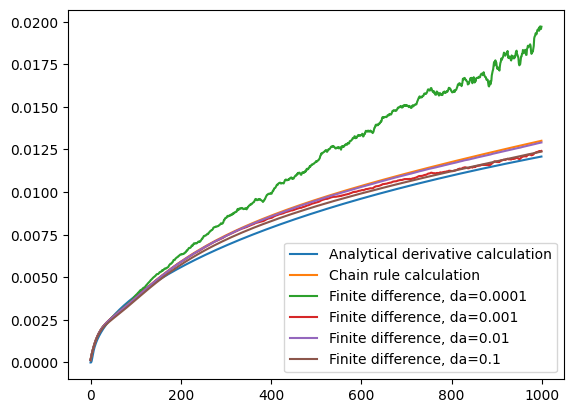

In [45]:
plt.plot(g_wrt_a_res, label="Analytical derivative calculation")
plt.plot(chainResult, label="Chain rule calculation")
plt.plot(fdResult0_0001, label="Finite difference, da=0.0001")
plt.plot(fdResult0_001, label="Finite difference, da=0.001")
plt.plot(fdResult0_01, label="Finite difference, da=0.01")
plt.plot(fdResult0_1, label="Finite difference, da=0.1")
plt.legend()

As expected, finite difference becomes increasingly unstable when reducing $da$, while chain rule stays both accurate and fast.

## Known code issues

1. Most of the C++ CFD module needs a rewrite.
   The design is outdated considering the current task and certain compile-time features selection doesn't work at all and causes a compilation errror.
1. In this notebook, we tried using the VT-100 command for clearing the line which doesn't work as intended for some reason
1. Despite seemingly having a compile-time feature selection via `Features` structure, CFD module actually doesn't have it.
   If you try to compile without `-DCALCULATE_CHAIN=true`, the compilation will probably fail with an error.
   The current implementation was written with a plan to account for different options, but it turned out to be problematic on the current codebase and requires a rewrite.
1. `Solver` copy-constructor needs a manual implementation since copy's layer views still point to original domain layers as it is now.
1. Without `-lpthread` ldflag, chain benchmark has convergence problems. Even with the flag, it still occasionally does. I have no idea why, since I can't reproduce this when building a CFD test binary 😐
1. The solver is not optimized to make use of __(6)__ being diagonal

In short: the code is essentially a proof-of-concept and is not ready for any outside use.
If you're still interested in it, follow [upstream NOA](https://github.com/grinisrit/noa) and [fork feature branch](https://github.com/gregthemadmonk/noa/tree/feature/cfd) for the updates.

## Some of the source code

### `benchmarkChain` source code

```cpp
m.def(
    "benchmarkChain",
    [] (std::size_t steps) -> Real {
        Solver solver;

        initSolver(solver, 40, 20);
        solver.cache();

        static constexpr auto gWrtP = [] (auto view, auto size, auto output) {
            output.forAllElements(
                [size] (auto, auto& v) {
                    v = Real{1} / size;
                }
            );
        };

        const auto cells = solver.getDomain().getMesh().template getEntitiesCount<Solver::dimCell>();

        using namespace noa::test::mhfe::methods;
        solver.template chainAInit<LMHFE>(gWrtP);

        for (std::size_t step = 0; step < steps; ++step) {
            solver.template step<LMHFE>();
            solver.template chainA<LMHFE>(gWrtP);
        }

        Real ret = 0;
        for (std::size_t cell = 0; cell < cells; ++cell) ret += solver.scalarWrtA[cell];
        return ret;
    }
);
```

### `benchmarkFindiff` source code

```cpp
m.def(
    "benchmarkFindiff",
    [] (std::size_t steps, Real da = 0.01) -> Real {
        Solver baseSolver;

        initSolver(baseSolver, 40, 20);
        baseSolver.cache();

        const auto cells = baseSolver.getDomain().getMesh().template getEntitiesCount<Solver::dimCell>();

        std::vector<Solver> solvers(cells);
        for (std::size_t cell = 0; cell < cells; ++cell) {
            auto& s = solvers.at(cell);
            initSolver(s, 40, 20);
            s.a[cell] += da;
            s.cache();
        }

        for (std::size_t step = 0; step < steps; ++step) {
            using namespace noa::test::mhfe::methods;
            baseSolver.template step<LMHFE>();
            for (auto&& s : solvers) s.template step<LMHFE>();
        }

        Real ret = 0;
        for (const auto& s : solvers) {
            for (std::size_t cell = 0; cell < cells; ++cell) ret += s.p[cell] - baseSolver.p[cell];
        }
        return ret / (cells * da);
    }
);
```

### `statChain` source code

```cpp
m.def(
    "statChain",
    [] (std::size_t steps) -> torch::Tensor {
        Solver solver;

        initSolver(solver, 10, 5);
        solver.cache();

        static constexpr auto gWrtP = [] (auto view, auto size, auto output) {
            output.forAllElements(
                [size] (auto, auto& v) {
                    v = Real{1} / size;
                }
            );
        };

        const auto cells = solver.getDomain().getMesh().template getEntitiesCount<Solver::dimCell>();

        using namespace noa::test::mhfe::methods;
        solver.template chainAInit<LMHFE>(gWrtP);

        const auto options = torch::TensorOptions().dtype(tdtReal<Real>);
        auto ret = torch::zeros(steps, options);

        for (std::size_t step = 0; step < steps; ++step) {
            solver.template step<LMHFE>();
            solver.template chainA<LMHFE>(gWrtP);

            for (std::size_t cell = 0; cell < cells; ++cell) ret[step] += solver.scalarWrtA[cell];
        }

        return ret;
    }
);
```

### `statFindiff` source code

```cpp
m.def(
    "statFindiff",
    [] (std::size_t steps, Real da = 0.01) -> torch::Tensor {
        Solver baseSolver;

        initSolver(baseSolver, 10, 5);
        baseSolver.cache();

        const auto cells = baseSolver.getDomain().getMesh().template getEntitiesCount<Solver::dimCell>();

        std::vector<Solver> solvers(cells);
        for (std::size_t cell = 0; cell < cells; ++cell) {
            auto& s = solvers.at(cell);
            initSolver(s, 10, 5);
            s.a[cell] += da;
            s.cache();
        }

        const auto options = torch::TensorOptions().dtype(tdtReal<Real>);
        auto ret = torch::zeros(steps, options);

        for (std::size_t step = 0; step < steps; ++step) {
            using namespace noa::test::mhfe::methods;
            baseSolver.template step<LMHFE>();
            for (auto&& s : solvers) s.template step<LMHFE>();

            for (const auto& s : solvers) {
                for (std::size_t cell = 0; cell < cells; ++cell) ret[step] += s.p[cell] - baseSolver.p[cell];
            }
            ret[step] /= (cells * da);
        }

        return ret;
    }
);
```

### `initSolver` source code

```cpp
static constexpr auto initSolver = [] (Solver& solver, int Nx, int Ny) {
    noa::utils::domain::generate2DGrid(
        solver.getDomain(),
        Nx, Ny,
        20.0 / Nx, 10.0 / Ny
    );

    solver.updateLayers();

    // Set up initial & border conditions
    const auto& mesh = solver.getDomain().getMesh();

    mesh.template forBoundary<Solver::dimEdge>([&solver, &mesh] (auto edge) {
        const auto p1 = mesh.getPoint(mesh.template getSubentityIndex<Solver::dimEdge, 0>(edge, 0));
        const auto p2 = mesh.getPoint(mesh.template getSubentityIndex<Solver::dimEdge, 0>(edge, 1));

        const auto r = p2 - p1;

        if (r[0] == 0) { // x = const boundary
            float x1v = 0;

            const bool mask = (p1[0] == 0) && (((p1 + r / 2)[1] > 4) && ((p1 + r / 2)[1] < 6));

            solver.dirichletMask[edge] = 1;
            solver.dirichlet[edge] = mask;
            solver.tp[edge] = mask;
        } else if (r[1] == 0) { // y = const boundary
            solver.neumannMask[edge] = 1;
            solver.neumann[edge] = 0;
        }
    });
    solver.a.forAllElements([] (auto i, auto& v) { v = 1; });
    solver.c.forAllElements([] (auto i, auto& v) { v = 1; });
};
```